In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict

from data_utilities import get_split
from pricing_utilities import (
    apply_biases,
    best_model,
    estimate_bias,
    evaluate_pricing,
    get_indices_by_quantile,
    get_price_intervals,
)

X_train, y_train, X_test, y_test = get_split(remove_all_nulls=True)

Loading raw dataset


In [2]:
# CV prediction
model = best_model()
pred_train = cross_val_predict(model, X_train, y_train)
mean_absolute_error(pred_train, y_train)

45.692739866454616

In [3]:
# Test prediction
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
mean_absolute_error(pred_test, y_test)

45.019375123635534

In [4]:
# Idea #0: use the prediction directly to price the policies
evaluate_pricing(pred_test, y_test)

Percent sold: 40.22
MAE of sold policies: 56.18


In [5]:
# Idea #1: Move all predictions together to be more adjusted to the 30% sold mark
bias = estimate_bias(pred_train, y_train)
print(f"Bias {bias:.2f}")
evaluate_pricing(pred_test + bias, y_test)

Bias 14.96
Percent sold: 31.07
MAE of sold policies: 55.71


<Axes: xlabel='competitor_lowest_price', ylabel='competitor_lowest_price'>

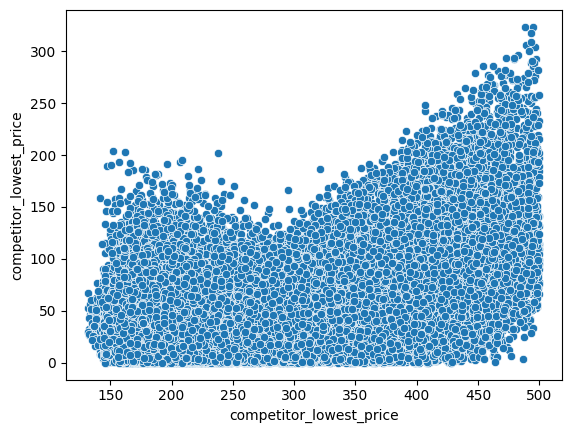

In [6]:
# The residuals of our model conditioned on the prediction aren't uuid
residuals_train = pred_train - y_train
sns.scatterplot(x=y_train, y=abs(residuals_train))

In [7]:
# Let's quantize the target variable and analyze the residuals on each interval
price_quantiles = get_price_intervals(pred_train)
print(f"Quantile intervals {price_quantiles}")
pred_indices_by_quantile = get_indices_by_quantile(pred_train)
bias_per_quantile = [
    residuals_train.take(idx).mean() for idx in pred_indices_by_quantile
]
error_per_quantile = [
    (residuals_train.take(idx) ** 2).mean() for idx in pred_indices_by_quantile
]
print(f"Biases {bias_per_quantile}")
print(f"Errors {error_per_quantile}")

Quantile intervals [[-inf, 190.81204180854758], [190.81204180854758, 209.53681708060387], [209.53681708060387, 231.52018255679158], [231.52018255679158, 261.10818065539235], [261.10818065539235, 311.47596708128066], [311.47596708128066, inf]]
Biases [-2.7734680143051302, 0.3071498456448103, 1.6654491218677228, 1.111118101323551, 0.6471867722455196, -1.0508905384572294]
Errors [1589.6770994857243, 2361.466710339412, 3246.5014844854463, 4522.309958304594, 5552.868032315787, 5306.181071354799]


<Axes: >

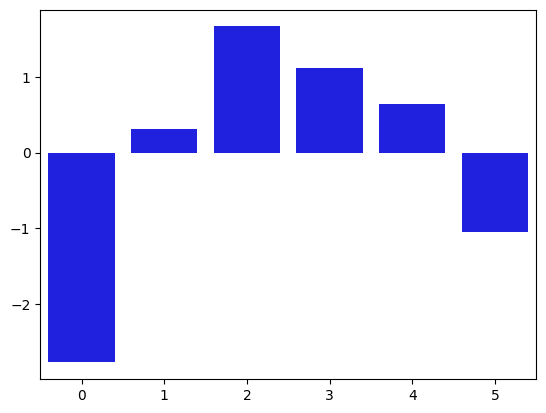

In [8]:
# Bias
sns.barplot(x=list(range(len(bias_per_quantile))), y=bias_per_quantile, color="b")

<Axes: >

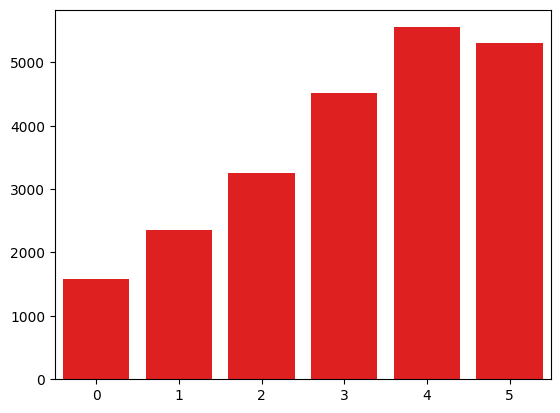

In [9]:
# Error
sns.barplot(x=list(range(len(error_per_quantile))), y=error_per_quantile, color="r")

In [10]:
# On each quantile predictions all have small bias but pricier policies have more error

# Idea #2: Estimate bias for each quantile, underselling 31% of policies of *every* quantile
bias_per_quantile = [
    estimate_bias(pred_train.take(idx), y_train.take(idx))
    for idx in pred_indices_by_quantile
]

# The result is we sell more policies on cheaper predictions, since we are more confident on these
print(bias_per_quantile)

pricing = apply_biases(pred_test, bias_per_quantile)
evaluate_pricing(pricing, y_test)

[6.362374033198751, 6.14113135388689, 8.162672367772181, 16.00587738900924, 27.111892342139768, 40.249310495710276]
Percent sold: 30.73
MAE of sold policies: 52.44


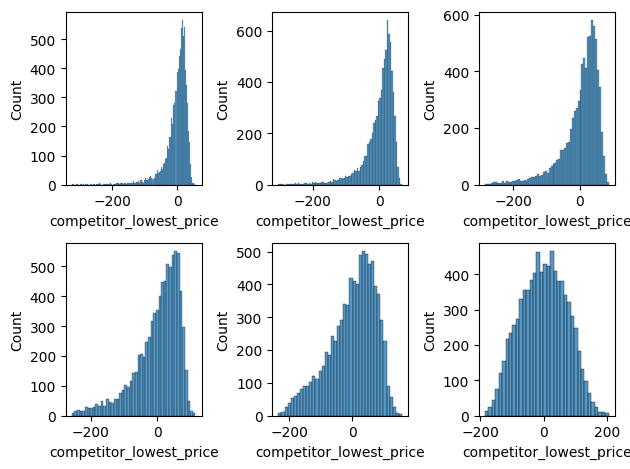

In [11]:
# Distributions of the residuals per quantile
fig, axs = plt.subplots(2, 3)

for ax, idx in zip(axs.flatten(), pred_indices_by_quantile):
    sns.histplot(residuals_train.take(idx), ax=ax)
plt.tight_layout()

In [12]:
# Idea #3: Try to get better biases by greedily adjusting them

from pricing_utilities import optimize_biases_greedy

estimated_mae, biases = optimize_biases_greedy(y_train, pred_train)
estimated_mae, biases

(39.14900869303657, [-25.0, -35.0, 125.0, 150.0, 130.0, 90.0])

In [13]:
evaluate_pricing(apply_biases(pred_test, biases), y_test)

Percent sold: 31.43
MAE of sold policies: 39.15


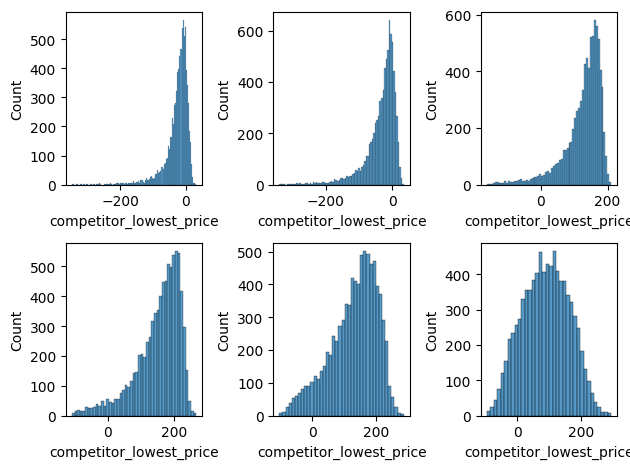

In [14]:
# Plot residuals adjusted with biases
# We are selling all policies with residuals under zero
# So most of the lower prediction policies and the ones we are most confident of in the highest quantiles
fig, axs = plt.subplots(2, 3)

for ax, b, idx in zip(axs.flatten(), biases, pred_indices_by_quantile):
    sns.histplot(residuals_train.take(idx) + b, ax=ax)
plt.tight_layout()

In [15]:
# Make prediction
from data_utilities import get_clean_data, get_raw_data

X_train, y_train, X_test = get_clean_data()
model = best_model().fit(X_train, y_train)
test_prediction = model.predict(X_test)
train_prediction = cross_val_predict(model, X_train, y_train, cv=20)
expected_mae, biases = optimize_biases_greedy(y_train, train_prediction)
print(expected_mae, biases)
evaluate_pricing(apply_biases(train_prediction, biases), y_train)
prices = apply_biases(test_prediction, biases)
_, test = get_raw_data()
ids = test["quote_id"]
df = pd.DataFrame({"quote_id": ids, "proposed_price": prices})
df.to_csv("proposed_prices.csv", index=None)

39.17513515617822 [-25.0, -35.0, 125.0, 175.0, 140.0, 80.0]
Percent sold: 32.28
MAE of sold policies: 39.18
